# Рынок заведений общественного питания Москвы
## Оглавление
* [Шаг №1. Загрузка данных и подготовка их к анализу](#h1_1)
* [Шаг №2. Анализ данных](#h1_2)
* [Общий вывод](#h1_3)
* [Шаг №3. Презентация для инвесторов](#h1_4)

## Описание проекта
В наличии имеются открытые данные о заведениях общественного питания г. Москва.
Необходимо провести исследование этих данных и подготовить презентацию, в которой отразить данные результаты.

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
import re
    
# Улучшение четкости изображения
%config InlineBackend.figure_format = 'retina'

# Увеличение максимального длины отображаемых значений таблицы
pd.set_option("max_colwidth", 300)

# Отключение предупреждений SettingWithCopyWarning
pd.options.mode.chained_assignment = None
    
# Функция для построения диаграммы размаха с сортировкой графиков по медиане
def boxplot_sorted(df, by, column, orient='v'):
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    meds = df2.median().sort_values(ascending=False)
    plt.figure(figsize=(12,6))
    with plt.style.context('seaborn'):
        sns.boxplot(data=df2[meds.index], orient=orient)

## Шаг №1. Загрузка данных и подготовка их к анализу<a class="anchor" id="h1_1"></a>


In [2]:
# Открытие файлов и создание датафреймов
rest_data = pd.read_csv('/datasets/rest_data.csv')

Посмотрим общую информацию и примеры данных:

In [3]:
rest_data.info()
display(rest_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50
...,...,...,...,...,...,...
15361,208537,Шоколадница,да,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50
15362,209264,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",10
15363,209186,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",20
15364,221900,Шоколадница,да,кафе,"город Москва, поселение Московский, Киевское шоссе, 22-й километр, домовладение 4, строение 1",36


### Название заведения
Подсчитаем количество уникальных названий заведений:

In [4]:
print(rest_data['object_name'].nunique())

10393


Приведем названия объектов к нижнему регистру и подсчитаем количество уникальных названий снова.

In [5]:
rest_data['object_name'] = rest_data['object_name'].str.lower()
print(rest_data['object_name'].nunique())

9924


### Тип заведения
Посмотрим уникальные значение видов заведений

In [6]:
print(rest_data['object_type'].value_counts())

кафе                                 6099
столовая                             2587
ресторан                             2285
предприятие быстрого обслуживания    1923
бар                                   856
буфет                                 585
кафетерий                             398
закусочная                            360
магазин (отдел кулинарии)             273
Name: object_type, dtype: int64


### Количество посадочных мест
Посмотрим на распределение количества посадочных мест.

count    15366.000000
mean        59.547182
std         74.736833
min          0.000000
25%         12.000000
50%         40.000000
75%         80.000000
max       1700.000000
Name: number, dtype: float64


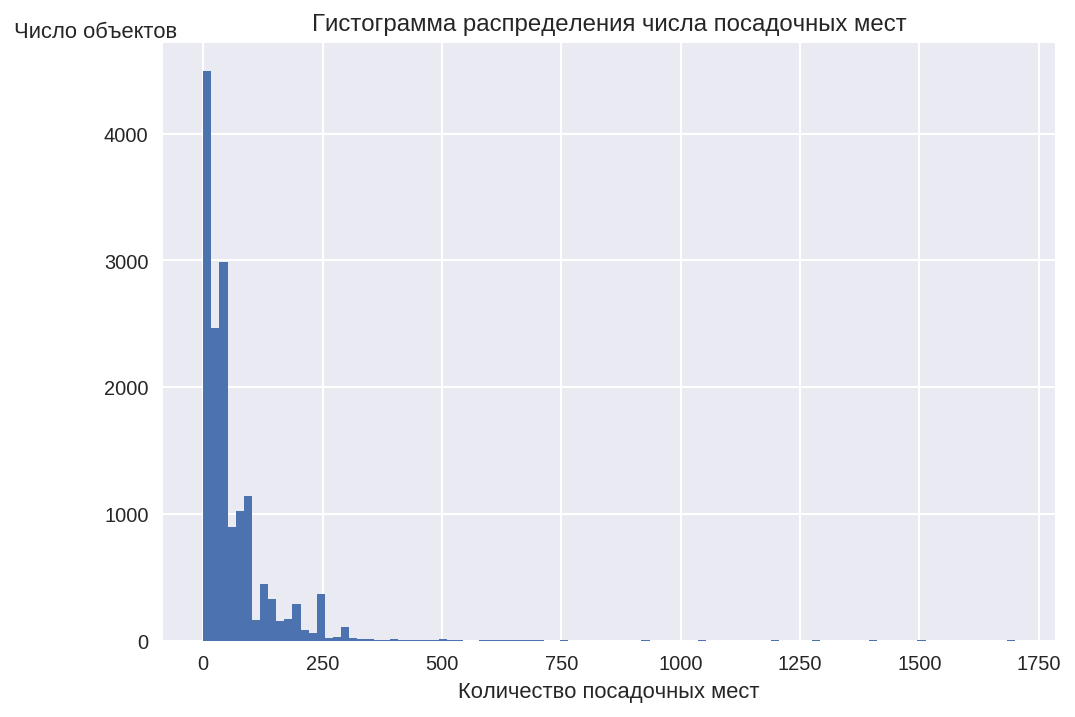

In [7]:
print(rest_data['number'].describe())
with plt.style.context('seaborn'):
    rest_data['number'].hist(bins=100)
    plt.title('Гистограмма распределения числа посадочных мест')
    plt.ylabel('Число объектов', rotation=0, position = (0,1))
    plt.xlabel('Количество посадочных мест')
    plt.show()

Имеются объекты с количеством посадочных мест, равным нулю. Возможно это не ошибка: например, такие заведения могут работать на вынос.

### Поиск дубликатов
Проверим датафрейм на наличие полных дубликатов:

In [8]:
print('Количество полных повторов в данных:',rest_data.duplicated().sum())

Количество полных повторов в данных: 0


Попробуем найти дубликаты по части основных колонок (название заведения, тип и адрес).

In [9]:
rest_data[(rest_data[['object_name','object_type','address']].duplicated())].sort_values(by='address').head(20)

,id,object_name,chain,object_type,address,number
5188,107466,кафе,нет,кафе,"город Москва, 1-я Останкинская улица, дом 55",5
5190,107480,кафе,нет,кафе,"город Москва, 1-я Останкинская улица, дом 55",5
5189,107471,кафе,нет,кафе,"город Москва, 1-я Останкинская улица, дом 55",4
5184,107456,кафе,нет,кафе,"город Москва, 1-я Останкинская улица, дом 55",10
5185,107442,кафе,нет,кафе,"город Москва, 1-я Останкинская улица, дом 55",20
5186,107574,кафе,нет,кафе,"город Москва, 1-я Останкинская улица, дом 55",10
5187,107462,кафе,нет,кафе,"город Москва, 1-я Останкинская улица, дом 55",5
5191,107485,кафе,нет,кафе,"город Москва, 1-я Останкинская улица, дом 55",6
9275,166766,кафе,нет,кафе,"город Москва, 19-й километр Московской Кольцевой Автодороги, владение 20, строение 1",42
2383,28616,комбинат питания мгту им.н.э.баумана,нет,закусочная,"город Москва, 2-я Бауманская улица, дом 5, строение 1",64


Многие из полученных дубликатов могут быть корректными для наших задач. Например, заведния с названием "кафе" могут встречаться, даже в одном здании. Комбинат питания МГТУ им.Н.Э.Баумана по данным университета действительно насчитывает множество столовых и буфетов.
Возможно среди данных записей действительно есть дубликаты, но тогда обрабатывать их нужно вручную, один за одним. Найденных записей не так много, чтобы они повлияли на результаты анализа, поэтому не будем их удалять.

### Выводы по шагу
* Загружены данные о заведениях. Пустых значений не обнаружено.
* Названия объектов приведены к нижнему регистру
* В данных имеются объекты с количеством посадочных мест, равным нулю. Скорее всего такие заведения могут работать на вынос и/или доставку.
* Полных дубликатов не найдено. Найдено немного частичных дубликатов, но многие из них корректны (для задач нашего исследования), поэтому решено их не удалять.

## Шаг №2. Анализ данных<a class="anchor" id="h1_2"></a>
### 1. Cоотношение видов объектов общественного питания по количеству.
Исследуем соотношение видов объектов общественного питания по количеству. 

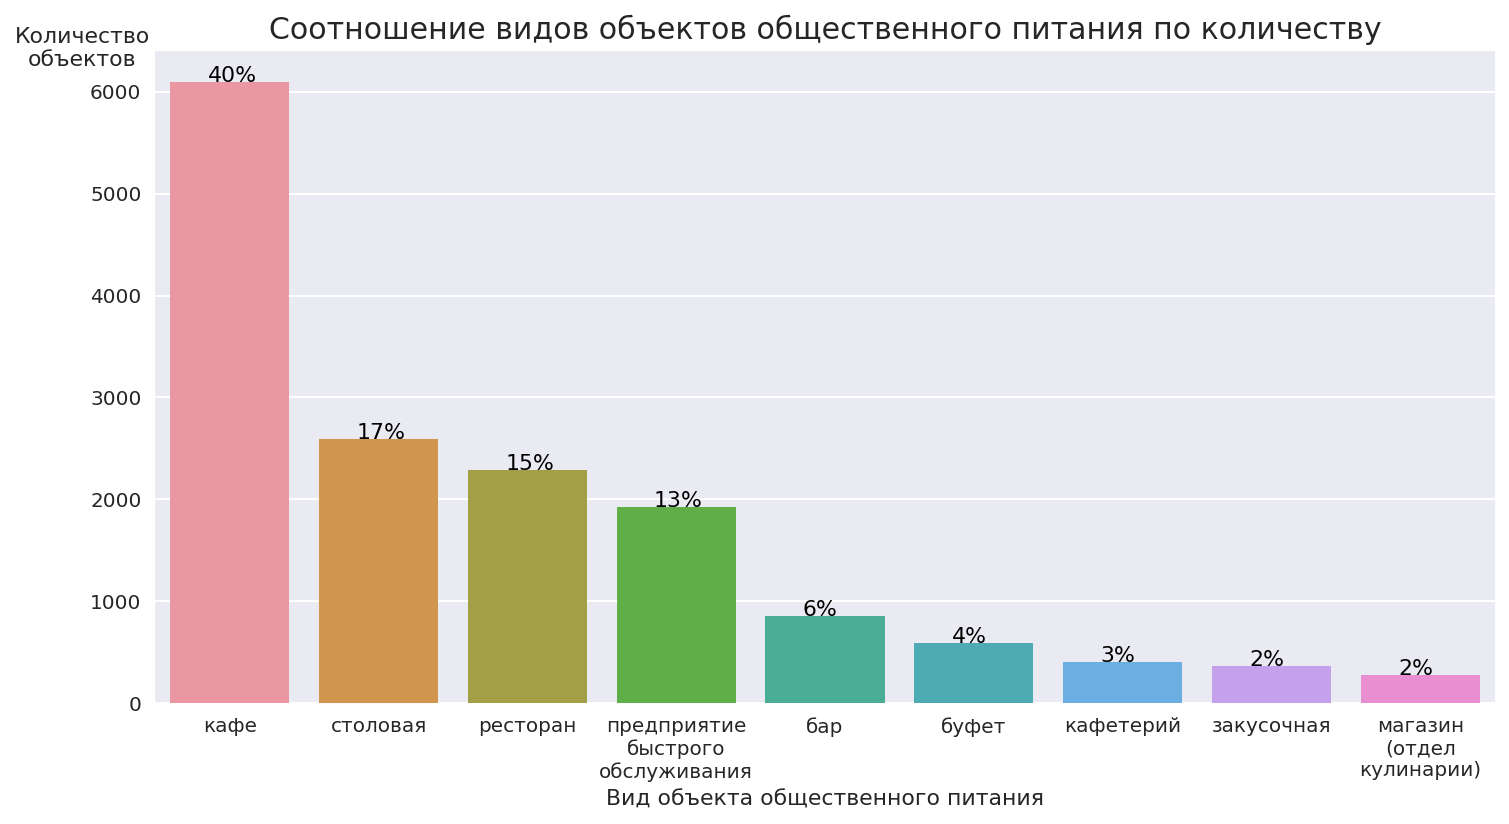

In [10]:
# Добавление символа конца строки в длинные названия видов объектов
rest_data['object_type'] = ['\n'.join(wrap(x, 12)) for x in  rest_data['object_type']]

# Создание сводной таблицы
objects_by_type = rest_data.groupby('object_type')['id'].agg('count').sort_values(ascending=False).reset_index()
objects_by_type.columns = ['object_type','count']

# Размер графика
plt.figure(figsize=(12,6))

# Построение графика
with plt.style.context('seaborn'):
    ax = sns.barplot(x='object_type', y='count', data=objects_by_type)

# Добавление подписей
plt.title('Cоотношение видов объектов общественного питания по количеству', fontsize=15)
plt.xlabel('Вид объекта общественного питания')
plt.ylabel('Количество\nобъектов', rotation=0, position = (0,0.97))

total = len(rest_data)
for p in ax.patches:
    percentage = '{:.0f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.15
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y), size = 11)
plt.show()

По количеству первое место занимают объекты вида кафе.

### 2. Cоотношение сетевых и несетевых заведений по количеству
Исследуем соотношение сетевых и несетевых заведений по количеству.

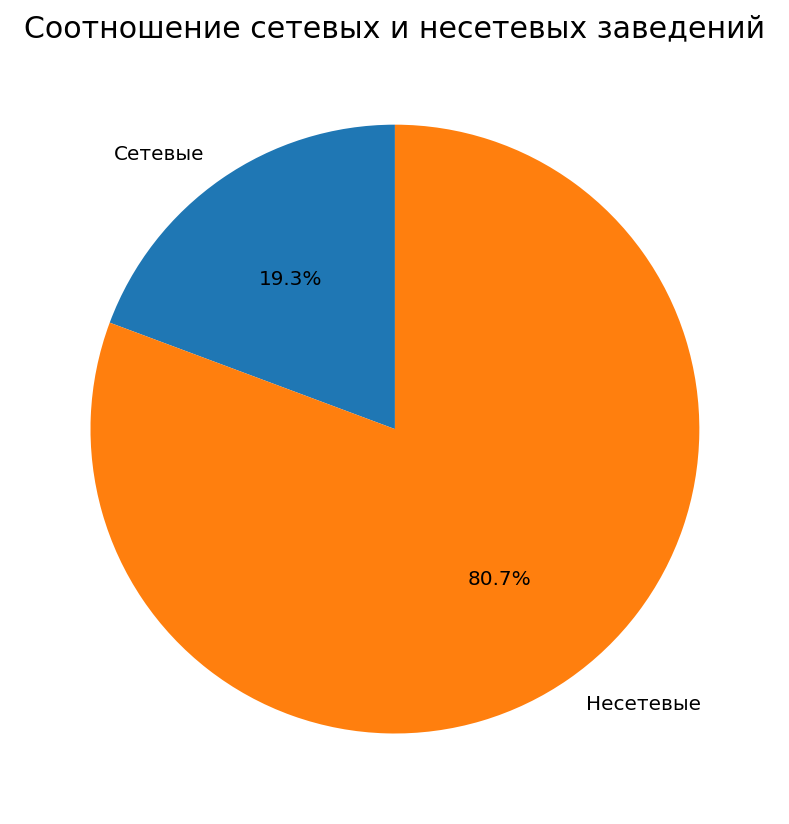

In [11]:
# Создание сводной таблицы с требуемыми данными
objects_chain = rest_data.groupby('chain')['id'].agg('count').sort_values().reset_index()

# Построение графика
labels_chain=['Сетевые', 'Несетевые']
plt.figure(figsize=(10,7))
plt.pie(objects_chain['id'], labels=labels_chain, autopct='%1.1f%%', startangle=90)
plt.title('Cоотношение сетевых и несетевых заведений', fontsize=15)
plt.show()

По полученным данным хорошо видно, что наибольшая часть заведений - несетевые.

### 3. Виды объектов общественного питания и сетевое распространение
Выясним, для какого вида объекта общественного питания характерно сетевое распространение.

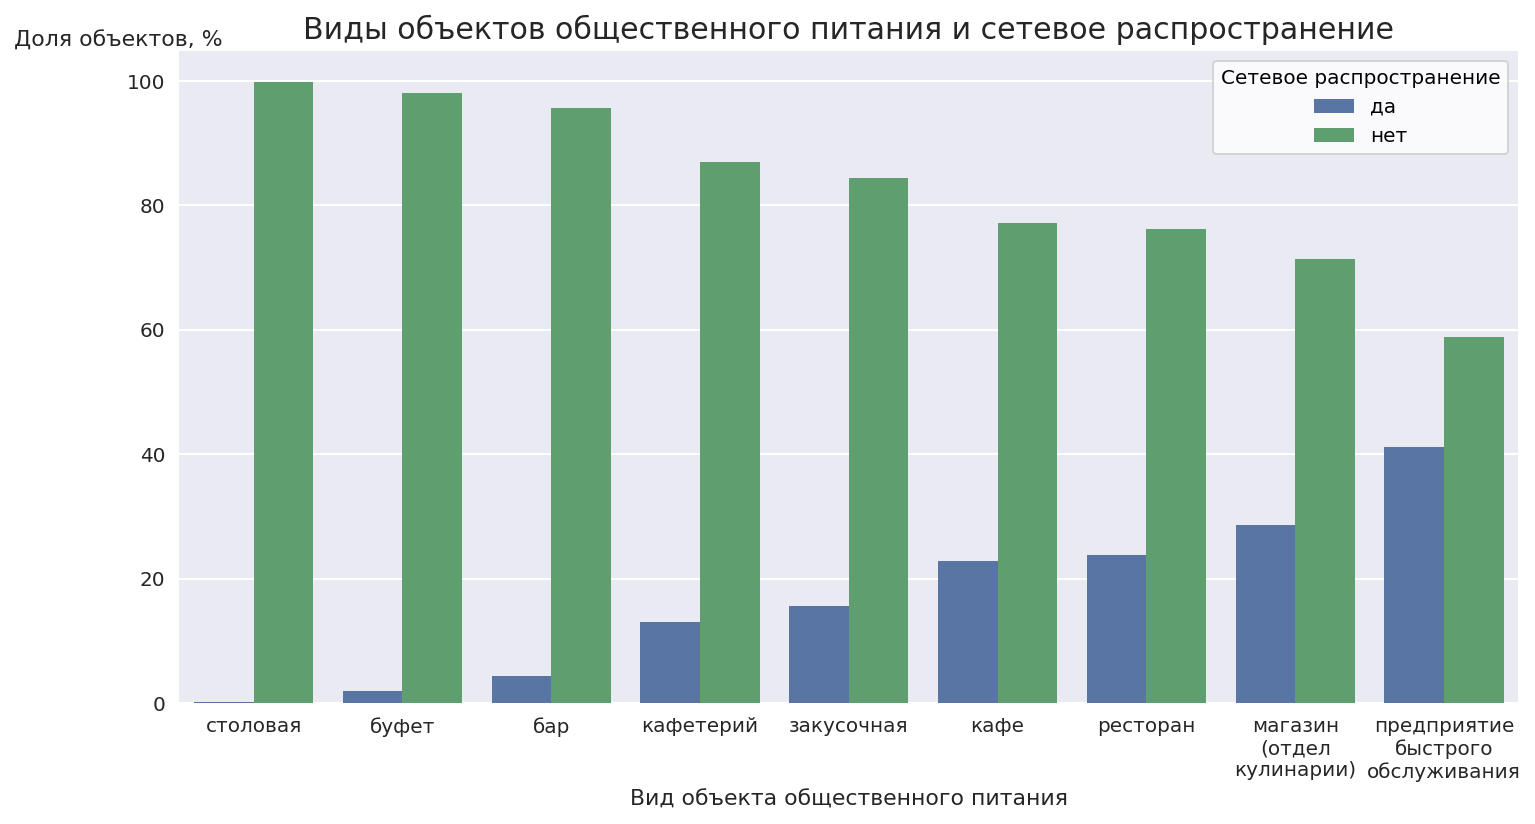

In [12]:
# Формирование сводной таблицы с количеством объектов по видам и типам распространения
objects_by_type_chain = rest_data.groupby(['object_type', 'chain'])['id'].agg('count').reset_index()

# Добавление колонки с суммой по виду объекта
objects_by_type_chain = objects_by_type_chain.merge(objects_by_type, left_on='object_type', right_on='object_type', how='left')

# Переименование колонок
objects_by_type_chain.columns = ['object_type','chain','number','sum']

# Добавление колонки с долей сетевого\несетевого распространения по каждому виду объекта
objects_by_type_chain['share'] = objects_by_type_chain['number'] / objects_by_type_chain['sum'] *100

# Сортировка по доле сетевого распространения
objects_by_type_chain= objects_by_type_chain.sort_values(by=['chain','share'], ascending=True)

# Построение графика
plt.figure(figsize=(12,6))
with plt.style.context('seaborn'):
    plot = sns.barplot(x='object_type', y='share', hue='chain', data=objects_by_type_chain)
      
plt.title('Виды объектов общественного питания и сетевое распространение', fontsize=15)
plt.xlabel('Вид объекта общественного питания')
plt.ylabel('Доля объектов, %', rotation=0, position = (0,1))
plt.legend(title ='Сетевое распространение')
plt.show()

Таким образом, сетевое распространение более всего характерно для предприятий быстрого обслуживания: доля сетевых объектов составляет около 40% среди заведений данного вида.

### 4. Посадочные места в сетевых заведениях
Посмотрим распределение количества мест в заведениях с сетевым распространением.

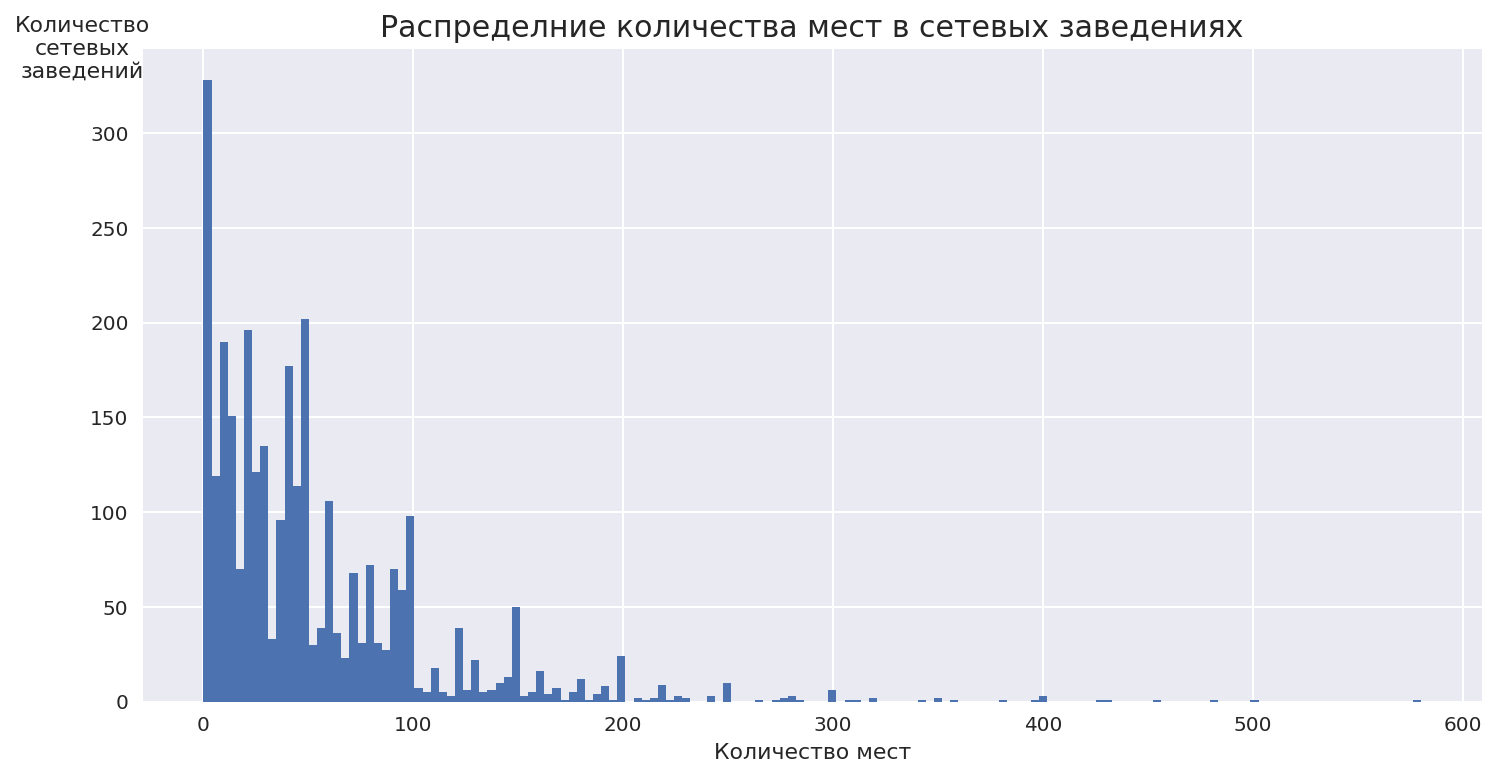

In [13]:
plt.figure(figsize=(12,6))
with plt.style.context('seaborn'):
    rest_data[rest_data['chain']=='да']['number'].hist(bins=150)
plt.title('Распределние количества мест в сетевых заведениях', fontsize=15)
plt.xlabel('Количество мест')
plt.ylabel('Количество\nсетевых\nзаведений', rotation=0, position = (0,0.95))
plt.show()

По гистограмме видно, что наибольшее количество сетевых заведений имеет небольшое число посадочных мест. В то же время совсем немного заведений имеет большое количество посадочных мест.
Причем для большого количества заведений количество мест равно 0, т.е. скорее всего такие заведения работают на вынос. Рассчитаем их количество:

In [14]:
print('Число заведений без посадочных мест:',len(rest_data[(rest_data['chain']=='да') & (rest_data['number']==0)]))

Число заведений без посадочных мест: 268


### 5. Посадочные места по видам объектов
Для каждого вида объекта общественного питания опишем среднее количество посадочных мест. Выясним, какой вид предоставляет в среднем самое большое количество посадочных мест.

Построим диаграмму со средним количеством посадочных мест по видам объектов.

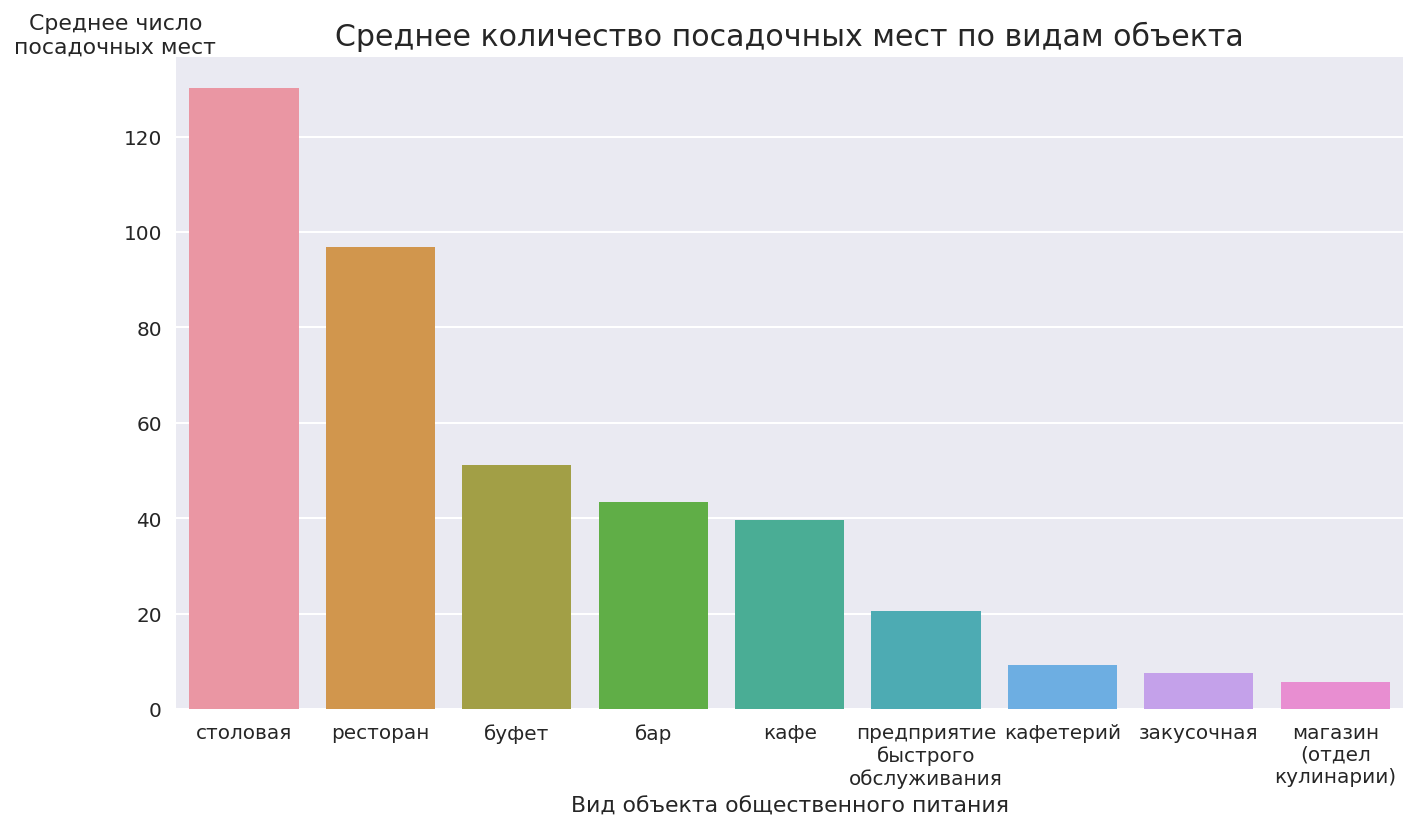

In [15]:
# Построение графика
plt.figure(figsize=(11,6))
with plt.style.context('seaborn'):
    sns.barplot(x='object_type', y='number', data=rest_data.groupby('object_type')['number'].agg('mean').sort_values(ascending=False).reset_index())
plt.title('Среднее количество посадочных мест по видам объекта', fontsize=15)
plt.xlabel('Вид объекта общественного питания')
plt.ylabel('Среднее число\nпосадочных мест', rotation=0, position = (0,1))
plt.show()

Поскольку распределение количества мест имеет большие хвосты, то возможн лучше использовать медианное значение. Построим диаграмму размаха по видам объектов.

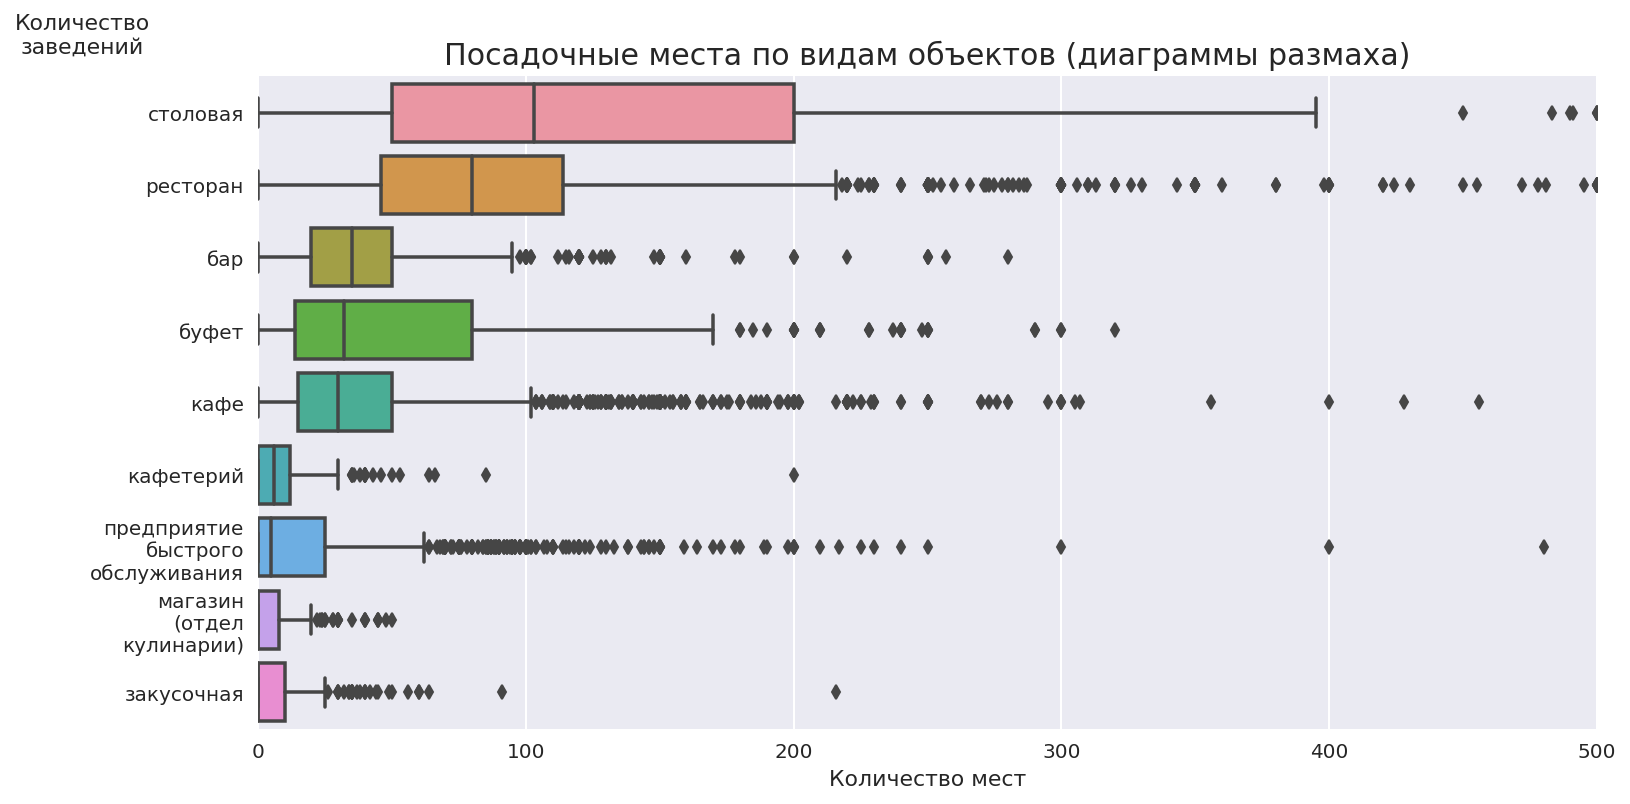

In [16]:
# Вызов функции построения диаграммы размаха
boxplot_sorted(rest_data, by="object_type", column="number", orient='h')

# Настройка осей и названия графика
plt.xlim(0, 500)
plt.title('Посадочные места по видам объектов (диаграммы размаха)', fontsize=15)
plt.xlabel('Количество мест')
plt.ylabel('Количество\nзаведений', rotation=0, position = (0,1.03))
plt.show()

В целом картина получилась схожая с графиком среднего количества посадочных мест: столовые и рестораны оказались лидерами среди сетевых заведений. Далее идут буфеты, бары и кафе. 

### 6. Выделение информации об улице
Выделим в отдельный столбец информацию об улице из столбца address .

In [17]:
# Создание списка ключевых слов, по которым будем выявлять из адреса название улицы
# В список включены значения ['город','поселение','деревня'], поскольку в адресах, где встречаются такие имена, улицы не указано
words = ['улица','ул','переулок','шоссе','проспект','площадь','проезд',
         'город','поселение','деревня','аллея','бульвар','набережная','тупик','линия','километр']

# Регулярное выражение для нахождения улицы
reg_exp = r".*,\s*\b([^,]*?(?:{})\b[^,]*)[,$]+".format("|".join(words))

rest_data['street'] = rest_data['address'].str.extract(reg_exp, flags=re.IGNORECASE)

Посмотрим, есть ли пустые значения в колонке с улицей.

In [18]:
rest_data[rest_data['street'].isna()]

,id,object_name,chain,object_type,address,number,street
394,150654,love,нет,кафе,"город Москва, 2-й квартал Капотня, дом 1",40,NaN
859,23601,буфет - гбоу сош № 64,нет,буфет,"Партизанская улица, дом 30",100,NaN
860,23604,буфет - гбоу 60,нет,буфет,"Партизанская улица, дом 30",100,NaN
1491,25349,ресторан «гранатовый сад»,нет,ресторан,"Поречная улица, дом 5/14, строение 1",40,NaN
1799,152815,предприятие быстрого обслуживания «бургер кинг»,да,предприятие\nбыстрого\nобслуживания,"город Москва, микрорайон Северное Чертаново, дом 1А",20,NaN
...,...,...,...,...,...,...,...
13768,175920,кальянная «лаундж-бар облако»,нет,бар,"город Москва, микрорайон Северное Чертаново, дом 1А",36,NaN
13991,204917,шаурма на углях- чайхана баракат,нет,кафе,"Таганская площадь, дом 88, строение 4",80,NaN
14003,211986,fresh cafe,нет,кафе,"Шарикоподшипниковская улица, дом 5, строение 1",42,NaN
14058,205702,предприятие быстрого обслуживания «кофепит»,нет,предприятие\nбыстрого\nобслуживания,"город Москва, микрорайон Северное Чертаново, корпус 208",0,NaN


### 7. Топ-10 улиц по количеству объектов
Построим график топ-10 улиц по количеству объектов общественного питания.

In [19]:
streets = rest_data.groupby('street')['id'].agg('count').sort_values().reset_index()
streets.columns=['street','count']
display(streets.tail(10))

,street,count
1959,Каширское шоссе,112
1960,Кутузовский проспект,114
1961,город Зеленоград,129
1962,проспект Вернадского,132
1963,Ленинский проспект,147
1964,Варшавское шоссе,161
1965,Пресненская набережная,167
1966,Ленинградский проспект,171
1967,Профсоюзная улица,182
1968,проспект Мира,204


В данные попал город Зеленоград. Исключим его из выборки и построим диаграмму с количеством объектов на улице.

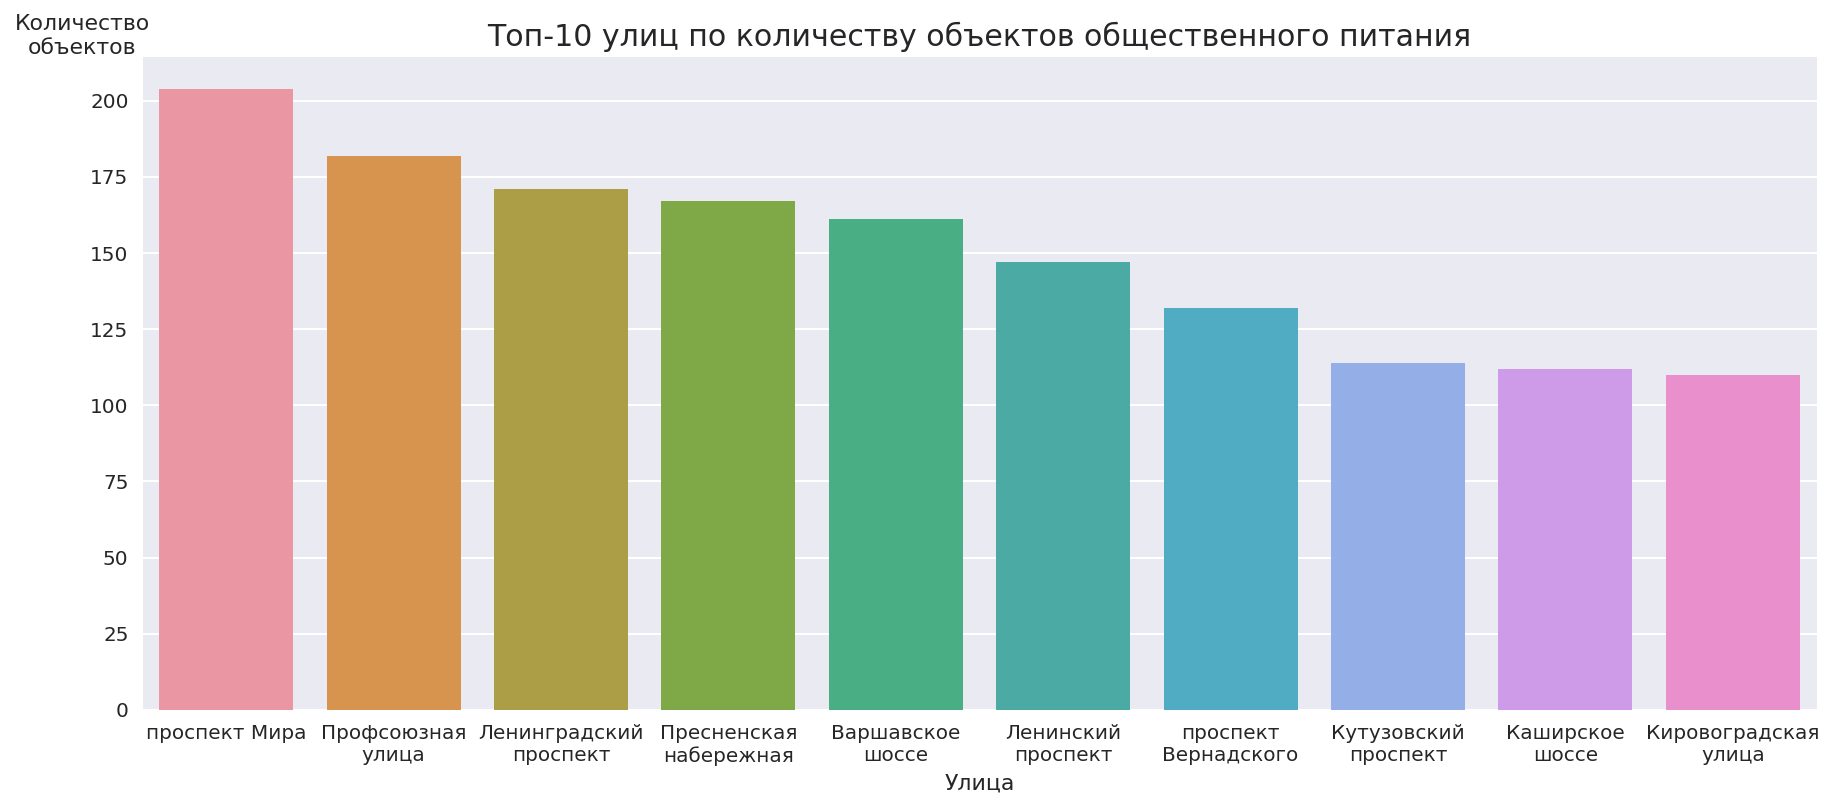

In [20]:
# Создание таблицы 10 улиц с наибольшим количеством заведений
streets_top10 = streets[streets['street'] != 'город Зеленоград'].tail(10).sort_values(by='count', ascending=False)


# Построение графика
plt.figure(figsize=(15,6))
with plt.style.context('seaborn'):
    sns.barplot(x='street', y='count', data=streets_top10)
    
# Создание подписей оси X с переносом строк для лучшего отображения:
plt.xticks(np.arange(10),['\n'.join(wrap(x, 14)) for x in  streets_top10['street']])

plt.title('Топ-10 улиц по количеству объектов общественного питания', fontsize=15)
plt.xlabel('Улица')
plt.ylabel('Количество\nобъектов', rotation=0, position = (0,1))
plt.show()

Почти все улицы из данного списка являются очень длинными улицами. Исключение - Пресненская набережная, длина которого всего 500 метров. Но по этой улице находятся здания делового центра Москва-Сити и крупных торговых центров. Поэтому концентрация заведений общественного питания здесь так высока.

Посмотрим, в каких районах Москвы находятся эти улицы. Для этого воспользуемся внешней информацией.

In [21]:
areas = pd.read_csv('https://raw.githubusercontent.com/Distans/temp/main/mosgaz-streets.csv')
display(areas)

,streetname,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район
...,...,...,...,...
4393,Вознесенский проезд,17,ЦАО,Пресненский район
4394,Волков переулок,17,ЦАО,Пресненский район
4395,Поварская улица,17,ЦАО,Пресненский район
4396,Кудринская площадь,17,ЦАО,Пресненский район


Определим, в каких районах находятся данные улицы:

In [22]:
# Объединение данных по улицам, находящихся в нескольких районах
areas = areas.groupby(['streetname'])['area'].apply(lambda text: ''.join(text.to_string(index=False))). str.replace('(\\n)', ',').reset_index()
# Объединение данных по топ-10 улицам и районам
streets_top10 = streets_top10.merge(areas, left_on='street', right_on='streetname', how='left')
# Удаление лишней колонки
streets_top10.drop('streetname', axis=1, inplace=True)
# Вывод полученной таблицы на экран
display(streets_top10)

,street,count,area
0,проспект Мира,204,"Алексеевский район, Ярославский Район, Район Марьина роща, Останкинский район, Район Ростокино, Район Свиблово, Мещанский район"
1,Профсоюзная улица,182,"Академический район, Район Черемушки, Район Ясенево, Район Коньково, Обручевский район, Район Теплый Стан"
2,Ленинградский проспект,171,"Район Аэропорт, Район Беговой, Хорошевский район, Район Сокол"
3,Пресненская набережная,167,Пресненский район
4,Варшавское шоссе,161,"Район Чертаново Центральное, Район Чертаново Северное, Район Чертаново Южное, Донской район, Район Нагатино-Садовники, Нагорный район, Район Северное Бутово, Район Южное Бутово"
5,Ленинский проспект,147,"Район Проспект Вернадского, Район Тропарево-Никулино, Донской район, Район Гагаринский, Ломоносовский район, Обручевский район, Район Теплый Стан, Район Якиманка"
6,проспект Вернадского,132,"Район Проспект Вернадского, Район Раменки, Район Тропарево-Никулино, Район Гагаринский, Ломоносовский район"
7,Кутузовский проспект,114,"Район Дорогомилово, Район Фили-Давыдково"
8,Каширское шоссе,112,"Район Москворечье-Сабурово, Район Нагатино-Садовники, Район Орехово-Борисово Южное, Район Орехово-Борисово Северное"
9,Кировоградская улица,110,"Район Чертаново Центральное, Район Чертаново Северное, Район Чертаново Южное"


Как видно, все длинные улицы находятся во множестве районов и заведения распределены по ним. Но насколько равномерно? На этот вопрос сложно ответить на основе имеющихся данных.

Посмотрим, в каких районах больше всего заведений:

In [23]:
# Объединение данных с районами
streets = streets.merge(areas, left_on='street', right_on='streetname', how='left')
# Удаление лишней колонки
streets.drop('streetname', axis=1, inplace=True)
# Подсчет количества заведений по районам
streets.groupby(['area'])['count'].agg('sum').sort_values(ascending=False).reset_index().head(15)

,area,count
0,Тверской район,550
1,Пресненский район,549
2,Басманный район,432
3,Район Хамовники,341
4,Даниловский район,292
5,Район Замоскворечье,285
6,Таганский район,262
7,Район Арбат,223
8,Хорошевский район,210
9,"Алексеевский район, Ярославский Район, Район Марьина роща, Останкинский район, Район Ростокино, Район Свиблово, Мещанский район",204


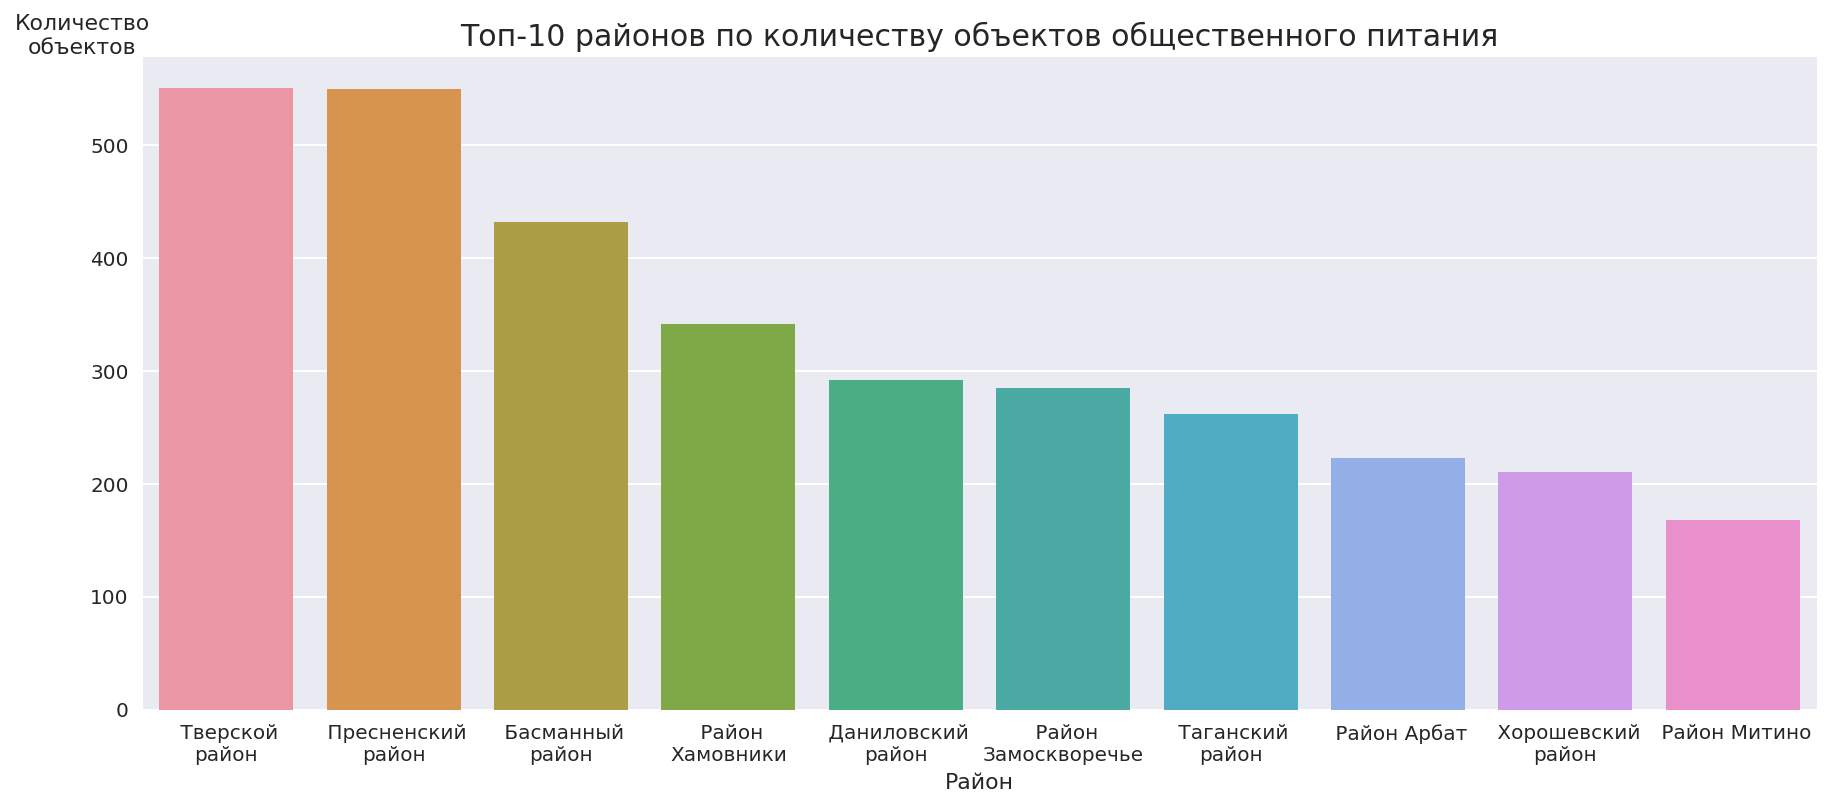

In [24]:
# Создание таблиц с топ-10 районов
areas_top10 = streets.groupby(['area'])['count'].agg('sum').sort_values(ascending=False).reset_index().loc[[0,1,2,3,4,5,6,7,8,12]]

# Построение графика
plt.figure(figsize=(15,6))
with plt.style.context('seaborn'):
    sns.barplot(x='area', y='count', data=areas_top10)
    
# Создание подписей оси X с переносом строк для лучшего отображения:
plt.xticks(np.arange(10),['\n'.join(wrap(x, 13)) for x in  areas_top10['area']])

plt.title('Топ-10 районов по количеству объектов общественного питания', fontsize=15)
plt.xlabel('Район')
plt.ylabel('Количество\nобъектов', rotation=0, position = (0,1))
plt.show()

Больше всего заведений в центральных районах города, находящихся в пределах Садового кольца.

### 8. Улицы с одним объектом 
Найдем число улиц с одним объектом общественного питания.

In [25]:
streets_one = streets[streets['count'] == 1]
print('Число улиц с одним объектом общественного питания: ',len(streets_one))
display(streets_one)

Число улиц с одним объектом общественного питания:  585


,street,count,area
0,Песчаный переулок,1,Район Сокол
1,Изваринская улица,1,Район Внуково
2,Известковый переулок,1,Таганский район
3,Измайловская площадь,1,Район Измайлово
4,деревня Яковлевское,1,NaN
...,...,...,...
580,Аэрофлотская улица,1,Район Внуково
581,улица Фадеева,1,Тверской район
582,Балтийская улица,1,"Район Аэропорт, Район Сокол"
583,Ащеулов переулок,1,Красносельский район


Посмотрим, в каких районах Москвы находятся эти улицы. Для этого воспользуемся внешней информацией.

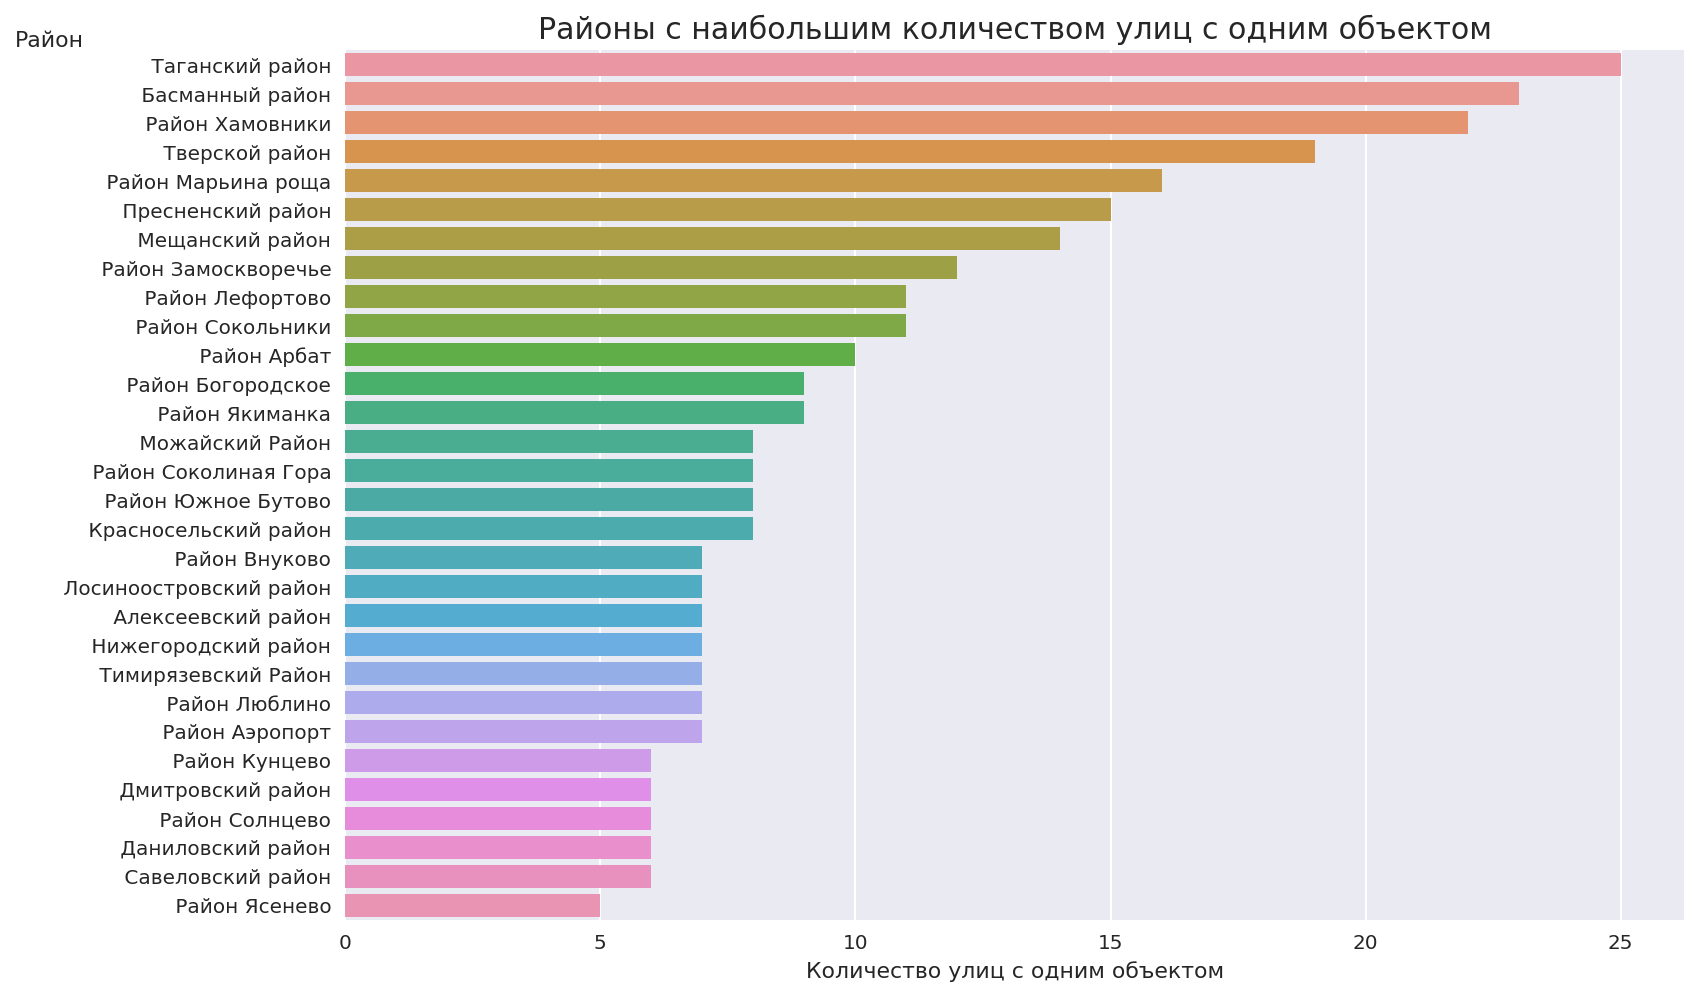

In [26]:
plt.figure(figsize=(12,8))
sns.set_color_codes("pastel")
with plt.style.context('seaborn'):
    sns.barplot(y='area', x='count', orient="h", data=streets_one.groupby('area')['count'].agg('count').sort_values(ascending=False).head(30).reset_index())
plt.title('Районы с наибольшим количеством улиц с одним объектом', fontsize=15)
plt.ylabel('Район', rotation=0, position = (0,1))
plt.xlabel('Количество улиц с одним объектом')
plt.show()

Наибольшее количество улиц с одним заведением находится в центральный районах города, в пределах Садового кольца или близко к нему.
Скорее всего так происходит из-за двух факторов:
1. В центре города в целом концентрация заведений общественного питания выше.
1. В центре города много небольших коротких улиц.

### 9. Посадочные места для улиц с большим количеством объектов
Построим распределение количества посадочных мест для улиц с большим количеством объектов общественного питания. Посмотрим, есть ли какие-то закономерности.


Гистограммы распределения посадочных мест для улиц с большим количеством объектов:


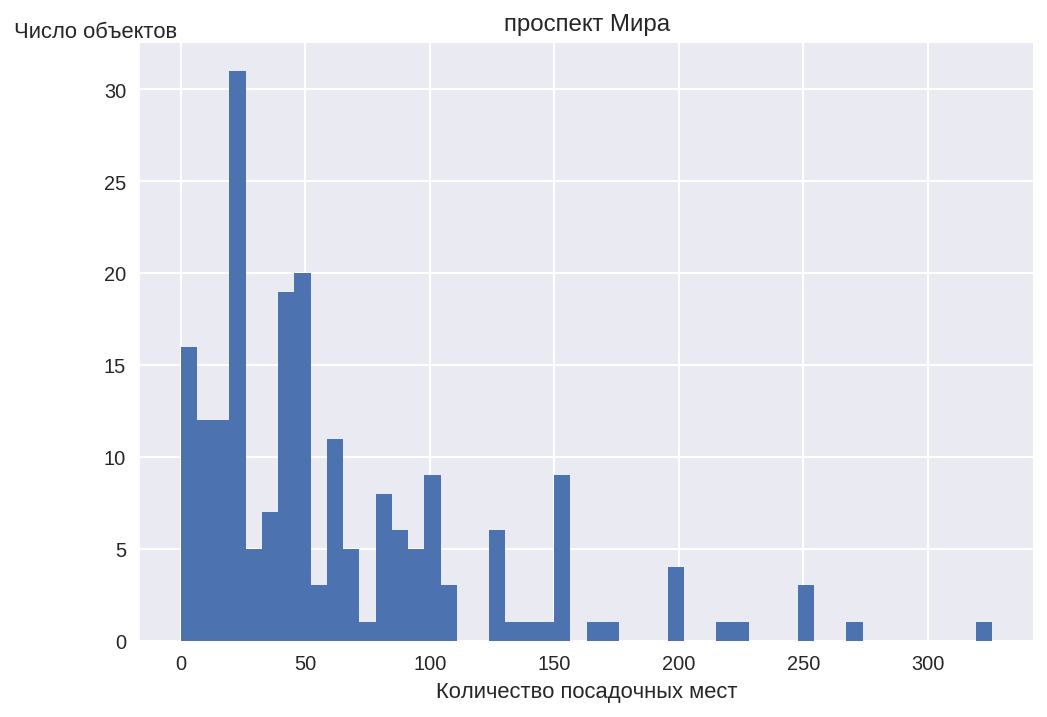

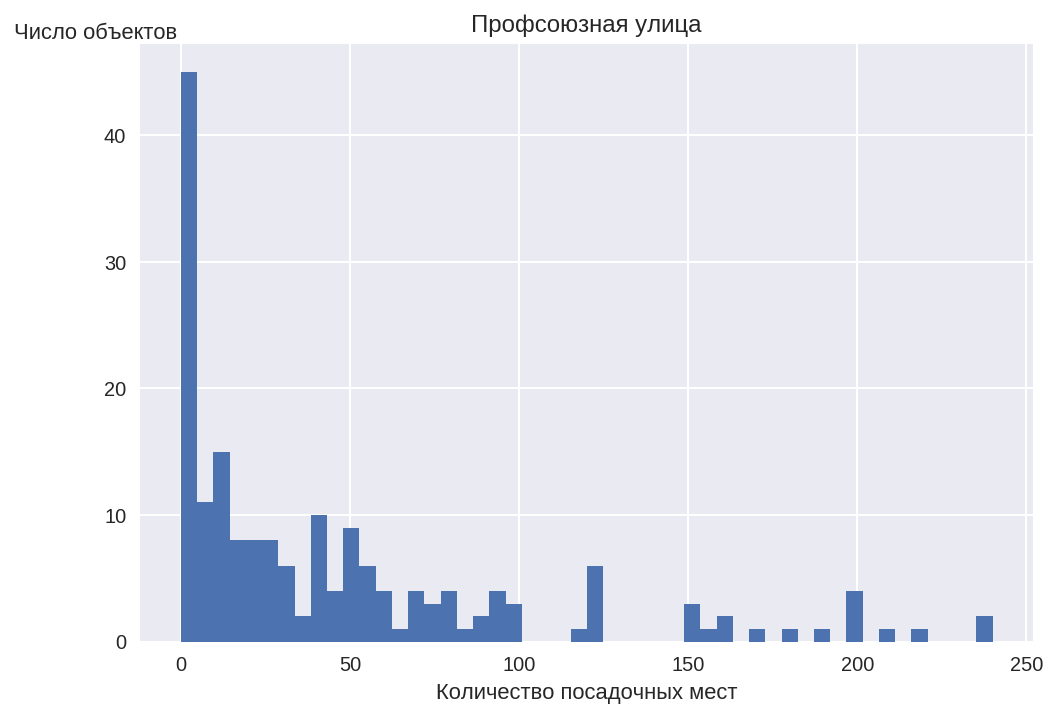

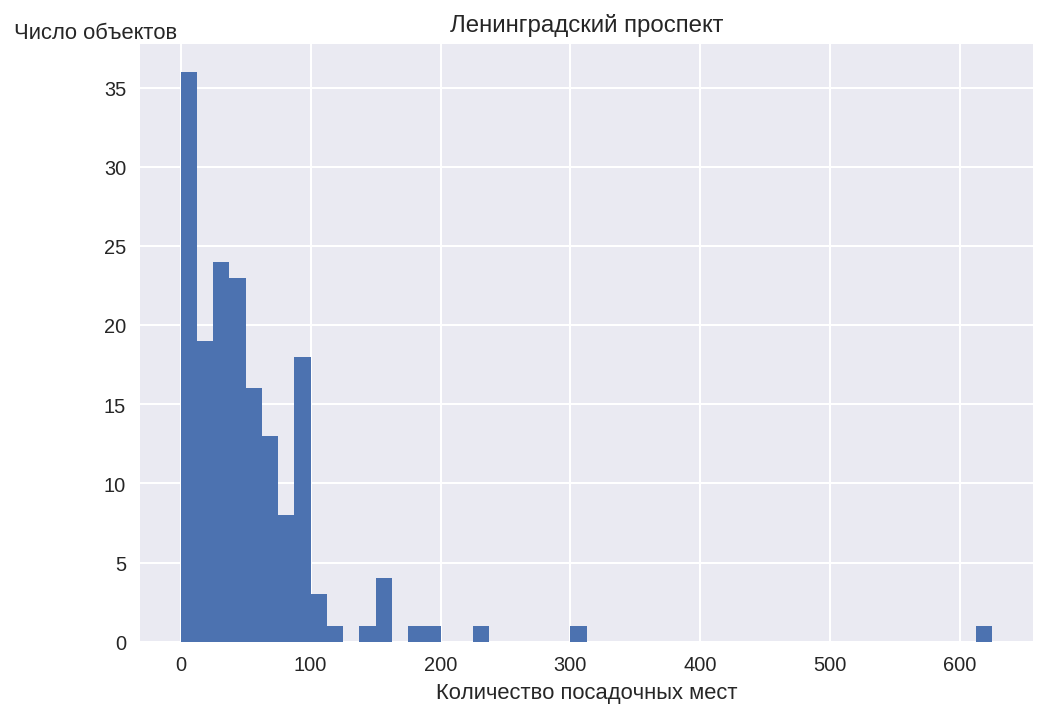

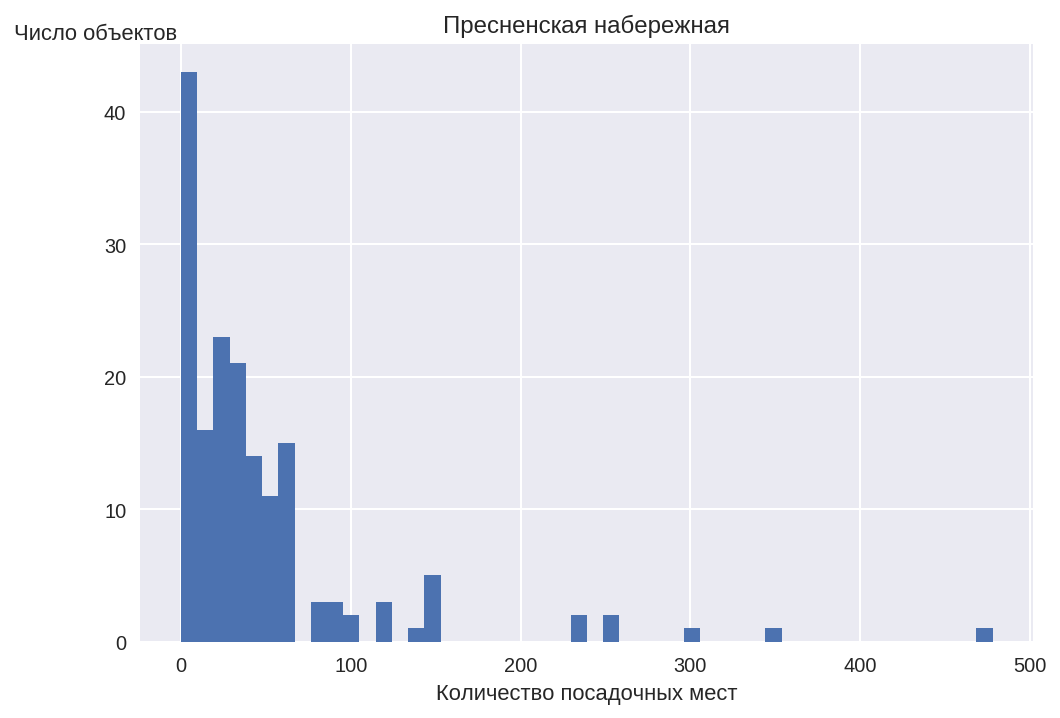

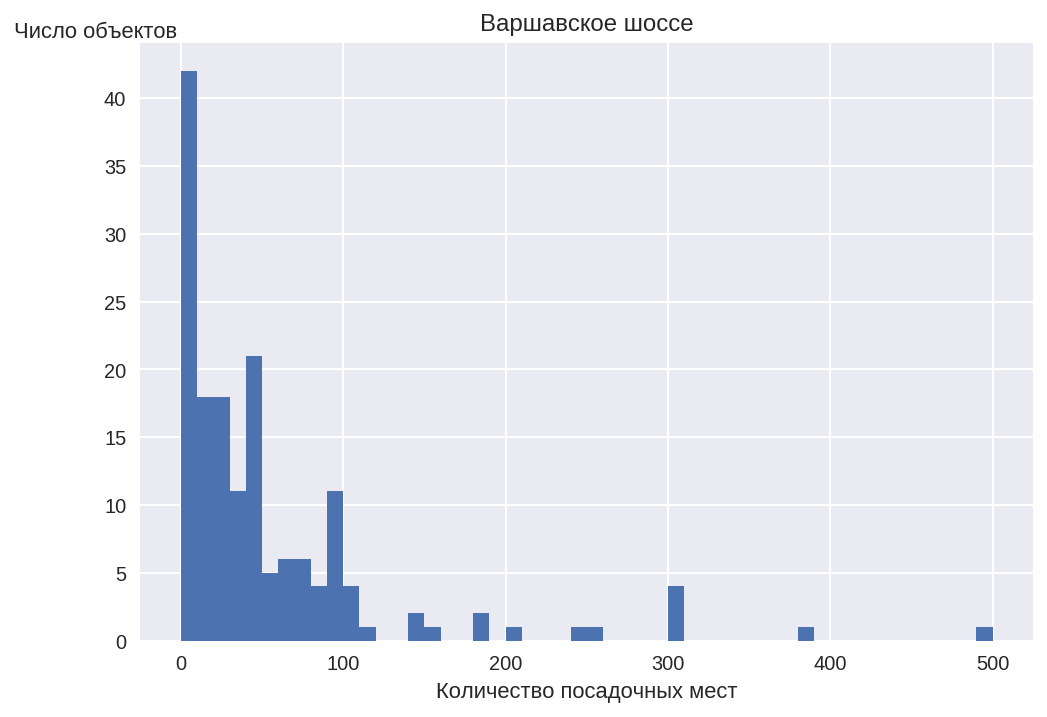

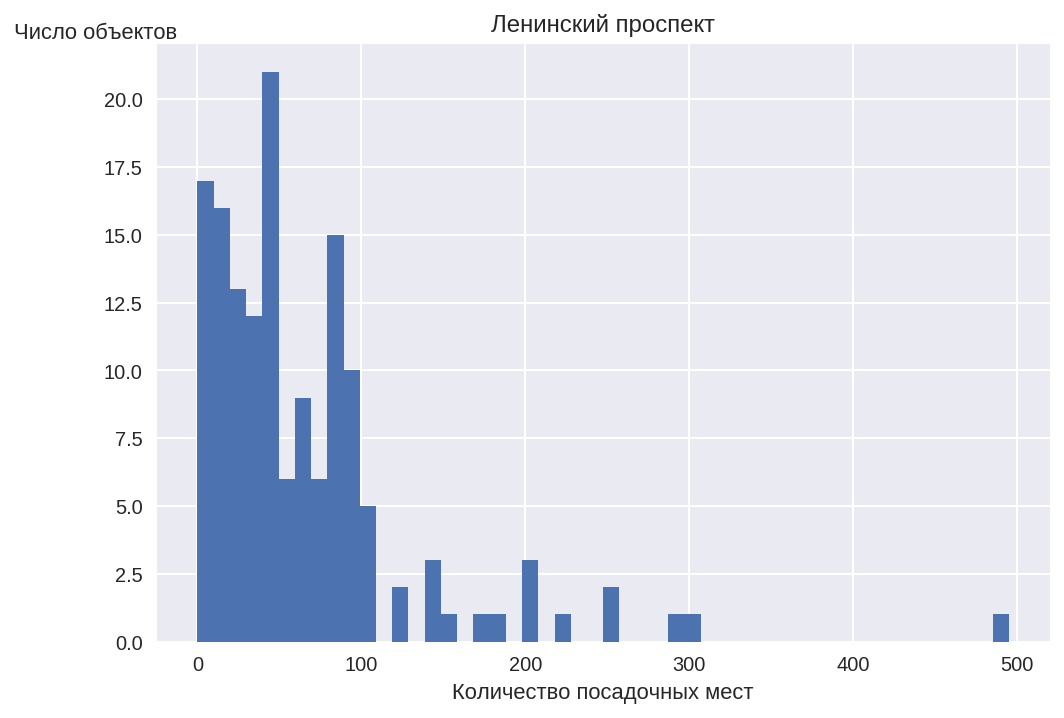

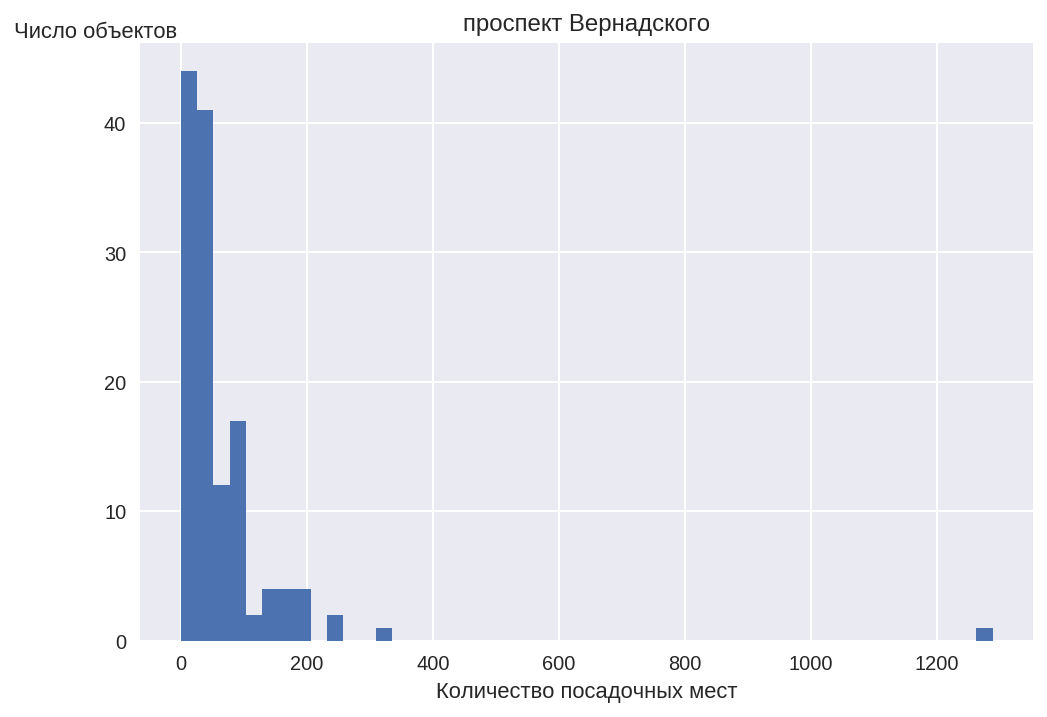

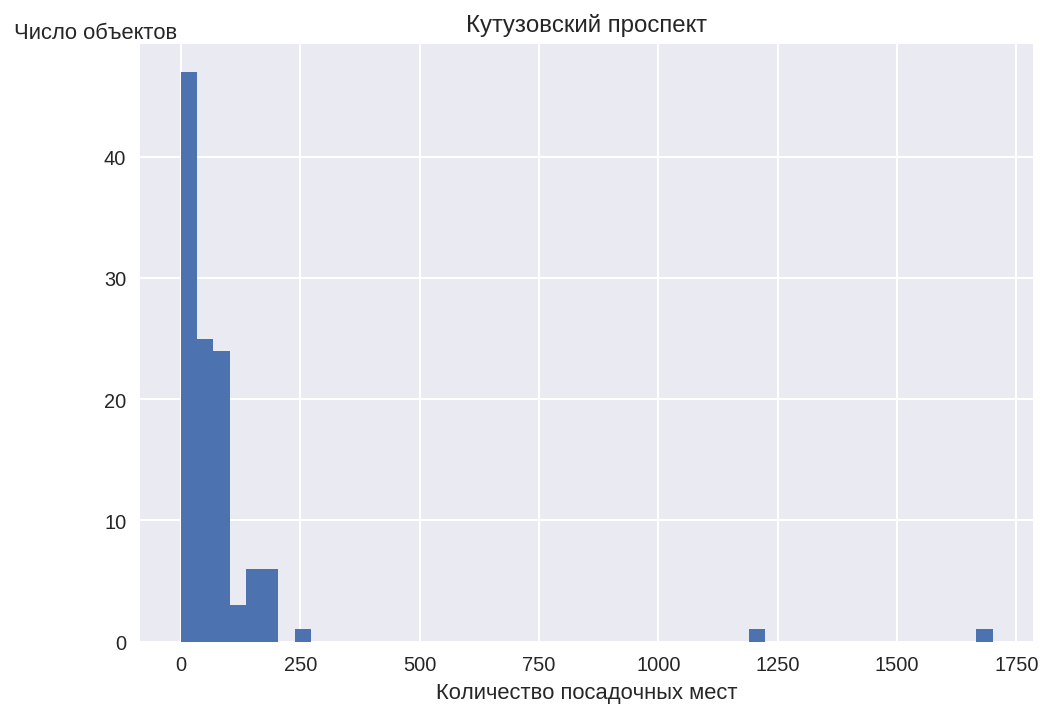

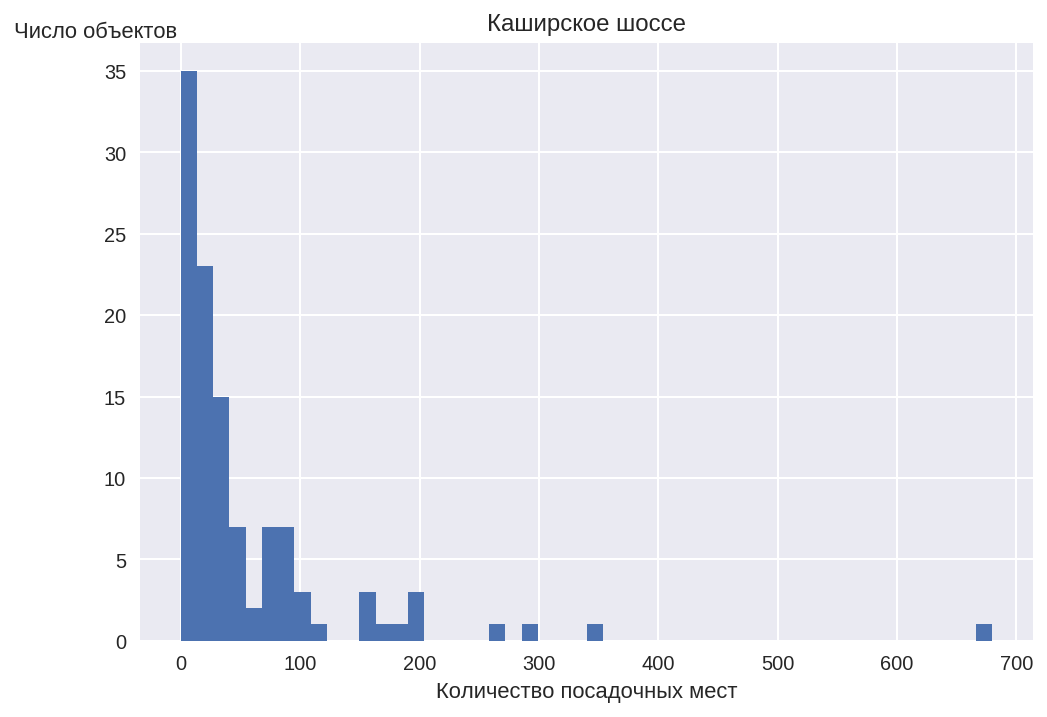

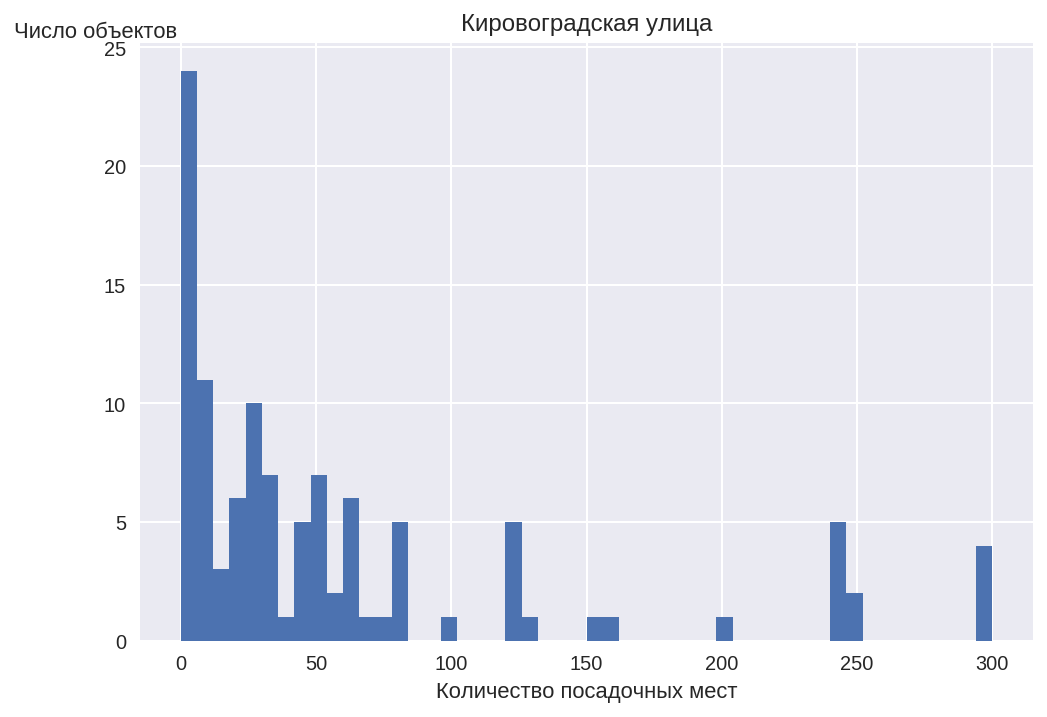

In [27]:
print('Гистограммы распределения посадочных мест для улиц с большим количеством объектов:')
streets_top10_names = streets_top10['street']
for item in streets_top10_names:
    with plt.style.context('seaborn'):
        rest_data.query('street == @item')['number'].hist(bins=50)
        plt.title(item)
        plt.ylabel('Число объектов', rotation=0, position = (0,1))
        plt.xlabel('Количество посадочных мест')
        plt.show()

Похоже, что по всем крупным улицам большая часть объектов имеет число посадочных мест в пределах 100. 

Для большей наглядности попытаемся отобразить полученные данные на одном графике.

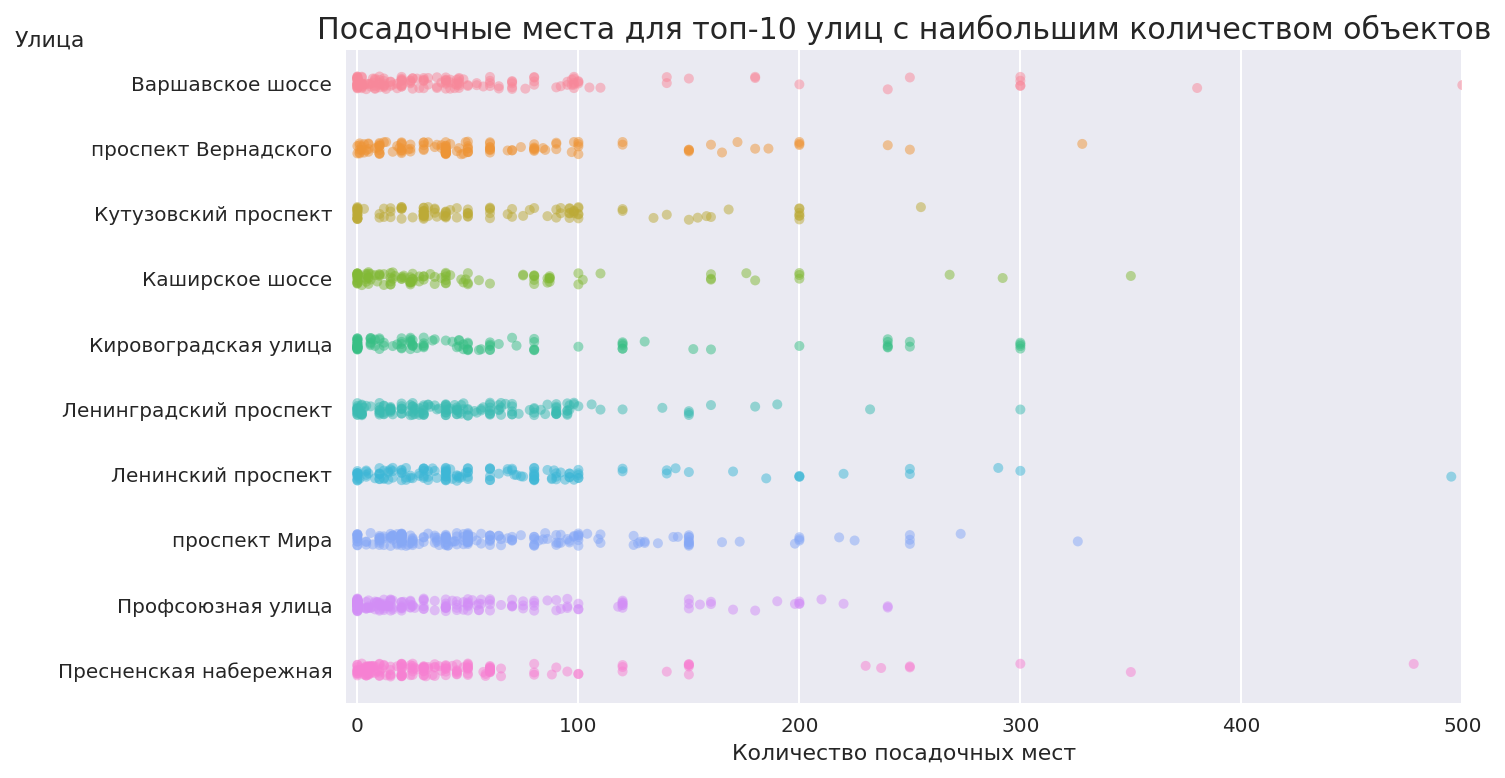

In [28]:
plt.figure(figsize=(10,6))
with plt.style.context('seaborn'):
    sns.stripplot(x="number", y="street", data=rest_data[rest_data['street'].isin(streets_top10_names)], alpha=0.5)
plt.xlim(-5, 500)
plt.title('Посадочные места для топ-10 улиц с наибольшим количеством объектов', fontsize=15)
plt.ylabel('Улица', rotation=0, position = (0,1))
plt.xlabel('Количество посадочных мест')
plt.show()

На графике достаточно хорошо видно, что наибольшее количество заведений имеют число посадочных мест в пределах 100 и со средним значением не более 50.

На всякий случай построим диаграмы размаха, чтобы увидеть картину точнее.

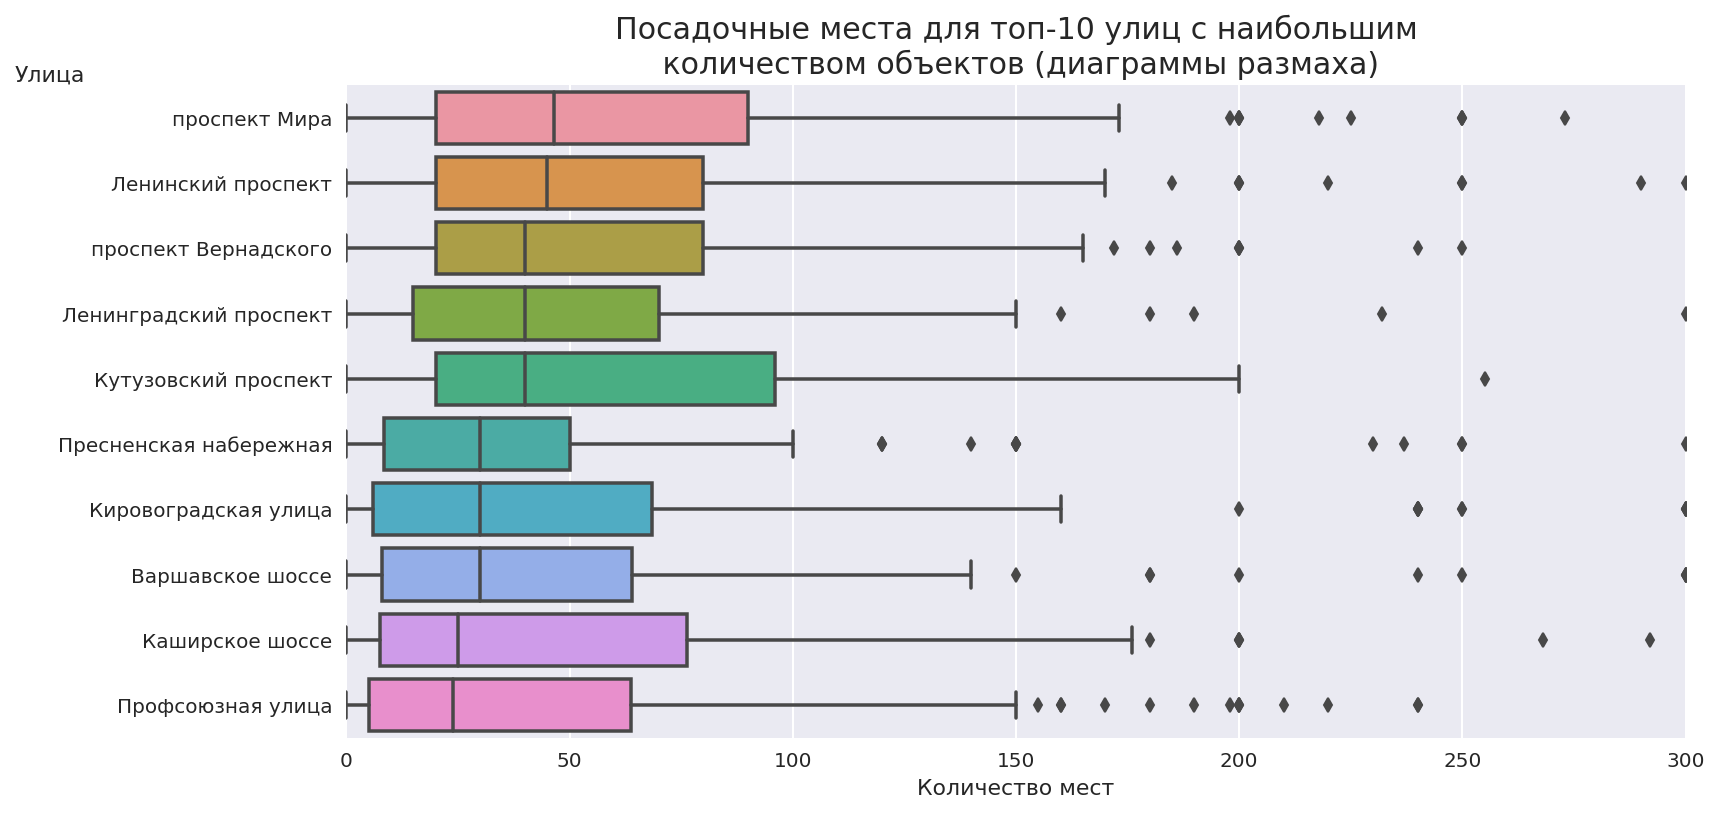

In [29]:
# Построение диаграммы размаха
boxplot_sorted(rest_data[rest_data['street'].isin(streets_top10_names)], by="street", column="number", orient='h')

# Настройка осей и названия графика
plt.xlim(0, 300)
plt.title('Посадочные места для топ-10 улиц с наибольшим\n количеством объектов (диаграммы размаха)', fontsize=15)
plt.xlabel('Количество мест')
plt.ylabel('Улица', rotation=0, position = (0,1))
plt.show()

## Общий вывод<a class="anchor" id="h1_3"></a>

На основе проведенного анализа можно сделать следующие выводы:
1. Наиболее популярные вид объекта - кафе. Далее идут столовые, рестораны, предприятия быстрого обслуживания. Кафе занимает 40% от общего числа объектов, другие три примерно по 15%.
1. Всего 20% заведений являются сетевыми. Причем сетевое распространеие более характерно для предприятий быстрого обслуживания: около 40% заведений данного типа сетевые. Для сетевых заведений характерно много объектов с очень небольшим числом посадочных мест в каждом и мало объектов с большим количеством посадочных мест. Т.е. сетевые заведения ориентированы на приготовление еды на вынос.
1. По количеству посадочных мест лидируют столовые и рестораны.
1. Улицы с наибольшим количеством заведений - длинные улицы, проходящие через несколько районов.
1. Больше всего заведений в центральных районах города, находящихся в пределах и вблизи Садового кольца.

Таким образом, наиболее подходящим для открытия будет заведение вида кафе в центре города с количеством посадочных мест около 50. Для развития сети предприятию желательно иметь возможность готовить еду на вынос.

## Шаг №3. Подготовка презентации<a class="anchor" id="h1_4"></a>

Презентация: https://www.dropbox.com/s/h0ves669kuiihbq/project_9_galtsev_pres.pdf?dl=0